##### Documentation: In neuroscience, fiber photometry combined with bulk calcium imaging is a method utilized to record the activity of a defined neuronal population in a target brain region in a free-moving animal performing a given task. In this method, a virus containing a calcium indicator (i.e. AAV-DIO-GCaMP) is injected in the brain region of interest and an optical fiber is implanted nearby the brain region of interest that now expresses the calcium indicator. Through the optical fiber, an excitation light is delivered and the overall fluorescence induced by calcium-activity during the light excitation is collected. Fiber photometry sums up the overall fluorescence of neurons expressing the genetically encoded calcium indicator, GCaMP, and can be used as a proxy for neuronal activation. The typical setup for freely behaving animals consists of the excitation light source (470 nm - to excite GCaMP), the beamsplitter/combiner that separates excitation and fluorescence light, the fiber-optic rotary joint, the optical cannula and connecting fiber-optic patch cords. Our set-up also contains an autofluorescence light (405 nm) which is used as a control light to account for photobleaching and movement artifacts (Beas et al 2018).  
##### The purpose of this code is to analyze and calculate DF/F for photometry recordings from a mouse expressing GCaMP in the paraventricular nucleus of the thalamus (PVT) as in (Beas et al 2018). The activity of neurons of the PVT were recorded while the mouse ate food pellets. 
##### After imaging from mice, three documents were exported from the photometry set up: 1- autofluorescence signal. 2- GCaMP signal  (our photometry rig collects 8 samples per second for both the GCaMP and the autofluorescence). 3- TTL pulses showing the times when the mouse ate a food pellet. 

#### ΔF/F0 analysis: As in Beas et al 2008, this code will analyze data by first applying  a least-squares linear fit to the 405-nm signal (auto) to align it to the 470-nm signal (GCaMP).  																		The resulting fitted 405-nm signal was then used to normalize the 473-nm signal as follows:																				
### ΔF/F0 = (473-nm signal − fitted 405-nm signal)/fitted 405-nm signal. 						

In [2]:
#Import packages needed
import pandas as pd
import numpy as np
from pylab import *
import matplotlib.lines as mlines #matplotlib
import matplotlib.pyplot as plt #matplotlib
plt.style.use('ggplot') #emulate ggplot from R
% matplotlib inline 
#view plots in jupyter notebook

## 1.- Load Auto, GCamp and Pulses data

In [3]:
auto = pd.read_csv('./A1_food2_AF.csv') #Import autofluorescence signal file 
gc = pd.read_csv('./A1_food2_GC.csv') #Import GCaMP signal file 
pulses = pd.read_csv('./A1_food2_pulse.csv') #Import times (as pulses) when mouse ate a food pellet

In [4]:
#checking our auto file import
auto.head(2)

,BLOCK,EVENT,TIME,CHAN,Sampling_Freq,NumOfPoints,D0,D1,D2,D3,...,D119,D120,D121,D122,D123,D124,D125,D126,D127,Unnamed: 134
0,test-181023-133458,Dv2A,0.000000,1,1017.252625,128,0.177454,0.179541,0.181627,0.183712,...,1.909245,2.018489,2.133489,2.254447,2.381572,2.515072,2.655158,2.802047,2.955955,NaN
1,test-181023-133458,Dv2A,0.125829,1,1017.252625,128,3.117103,3.285710,3.462000,3.646199,...,126.763466,128.825577,130.900147,132.986847,135.085403,137.195480,139.316803,141.449036,143.591858,NaN


In [5]:
#checking our GC file import
gc.head(2)

,BLOCK,EVENT,TIME,CHAN,Sampling_Freq,NumOfPoints,D0,D1,D2,D3,...,D119,D120,D121,D122,D123,D124,D125,D126,D127,Unnamed: 134
0,test-181023-133458,Dv1G,0.000000,1,1017.252625,128,0.054792,0.056013,0.057252,0.058511,...,2.942753,3.124505,3.315684,3.516624,3.727663,3.949142,4.181409,4.424813,4.679705,NaN
1,test-181023-133458,Dv1G,0.125829,1,1017.252625,128,4.946445,5.225391,5.516909,5.821367,...,206.260223,209.602554,212.964767,216.346390,219.746857,223.165680,226.602387,230.056320,233.527054,NaN


In [6]:
#checking our pulses file import. Note that in TIME column denotes in seconds when the mouse ate a food pellet.
pulses.head(2)

,BLOCK,EVENT,TIME,CHAN,Sampling_Freq,NumOfPoints,D0
0,Subject1-181024-130008,PtC0,136,0,0,1,1
1,Subject1-181024-130008,PtC0,154,0,0,1,2


## 2.- Slice data frames into only columns of interest.  Photometry files export different readings of the GCaMP and auto signals in different colums (D0, D1, D2... etc) using different paramaters. In our analysis, we use D0 as the "raw" measurement of our signal. As a result, we discard the rest of the columns. 

In [7]:
# Slice data frames into only columns of interest. 
time = auto['TIME'].values # Time is needed to be able to determine when the mouse ate the pellet.
auto_d0 = auto['D0'].values # Raw autofluorescence signal 
gc_d0 = gc['D0'].values # Raw GCaMP signal 
master_df = pd.DataFrame(columns=('time', 'auto_d0', 'gc_d0'), index=np.arange(0,len(time)))

## 3.- Create a new master data frame that combines all the columns of interest (data needed for the analysis).

In [8]:
# Creating master data frame containing only the important columns needed for DF_F analysis from both auto and gcamp
master_df['time'] = time
master_df['auto_d0'] = auto_d0
master_df['gc_d0'] = gc_d0
master_df.head()

,time,auto_d0,gc_d0
0,0.000000,0.177454,0.054792
1,0.125829,3.117103,4.946445
2,0.251658,145.744949,237.014084
3,0.377487,382.443634,617.052856
4,0.503316,352.730865,564.134705


## 4.- Make the pulse d0 column equivalent to the auto and gcamp to be able to locate the gcamp and auto signal when the mouse was eating. 

In [9]:
# Insert new column (pulses_d0) into master dataframe. Initialize with zeros.
pulse_d0 = np.zeros(len(time))
pulse_d0[:5]

array([0., 0., 0., 0., 0.])

In [10]:
# Insert pulses_d0 into master dataframe
master_df['pulses_d0'] = pulse_d0
master_df.head(3)

,time,auto_d0,gc_d0,pulses_d0
0,0.000000,0.177454,0.054792,0.0
1,0.125829,3.117103,4.946445,0.0
2,0.251658,145.744949,237.014084,0.0


###  Check point- checking how may pulses we have and the length of the file

In [11]:
pulses_time = pulses['TIME'].values
print(len(pulses_time))
print(len(time))

25
14357


In [12]:
#round time to be able to localizate it better in our pulse time (since photometry rig takes 8 samples per second)
pulses_time = [round(t, 1) for t in pulses_time]
pulses_time[:2]

[136, 154]

In [13]:
#checking point for loacalizing the rows where pulses are located 
sub_set = master_df[master_df['time'] > 136] 
sub_set[sub_set['time'] < 136 + 0.1]

,time,auto_d0,gc_d0,pulses_d0
1081,136.021279,337.760132,485.206604,0.0


## 5.- Create a method that locates pulses

The method takes a array of pulse times and the master dataframe as inputs and returns an array of matching times in the master dataframe

In [14]:
#Localizing the pulse times in gcamp (GC) column and auto column
def locate_pulses(pt, master):
    results = []
    for element in pt:
        subset = master[master['time'] > element]
        record = subset[subset['time'] < element + 0.2]
        results.append(record['time'].values)
    return results
        
p_results = locate_pulses(pulses_time, master_df)
p_results[:5]

[array([136.0212786, 136.1471078]),
 array([154.014843, 154.140672]),
 array([166.0944383]),
 array([177.0415719, 177.1674011]),
 array([199.0616679, 199.1874969])]

In [15]:
#Getting rid of duplicate values found 
buffer = []
for el in p_results:
    buffer.append(el[0])
print(len(buffer))
print(buffer[:3])
p_results = buffer

25
[136.0212786, 154.01484299999998, 166.0944383]


## 6.- Set 'pulses_d0' values for matching records in Master Dataframe

In [16]:
# Mark down in pulses column with a 5 the time when the pulse occurred (replace the 0 with a 5).
for el in p_results:
    indx = master_df[master_df['time'] == el].index[0]
    master_df.loc[indx]['pulses_d0'] = 5


## 7.- Generate CSV with master data and pulses information

In [17]:
master_df.to_csv('./master_with_pulses.csv') 

In [18]:
# Checking that the 0 in pulses_d0 was replaced with a 5 in particular rows where the pulse happened 
subset = master_df[master_df['pulses_d0'] == 5]
subset.head()

,time,auto_d0,gc_d0,pulses_d0
1081,136.021279,337.760132,485.206604,5.0
1224,154.014843,336.522797,485.088226,5.0
1320,166.094438,336.857880,482.434509,5.0
1407,177.041572,336.672577,483.199310,5.0
1582,199.061668,336.933838,485.312592,5.0


In [19]:
pulse_onset_rows = [i for i in subset.index[:]]

In [20]:
subset.to_csv('./A1_pulse_onset_rows.csv')

## 8.- Identify the pulse onset and select the range for the analysis (For a deatiled explanation of DF_F analysis, please see Beas et al 2018 Methods section). 

In [69]:
#create pulses_onset
pulse_onset = 1081 #IMPORTANT - can change number to any of the numbers in pulse_onset_rows
if pulse_onset in pulse_onset_rows:
    print('pulse_onset =', pulse_onset)
else:
    raise ValueError('pulse_onset not found in pulse_onset_rows')
#create begin_input 
begin_input = pulse_onset - 40 #IMPORTANT - can change number to any number of rows before pulse onset
print('begin_input =', begin_input)
#create last_row
last_row = len(master_df) - pulse_onset - 1
#create end_input
end_input = pulse_onset + 80 #IMPORTANT - can change number to any number of rows after pulse onset or to last_row for the last row in the data set
print('end_input =', end_input)
#Important: Change pulse_onset value for each "pulse". 
    #Change "begin_input" to establish a baseline (pre-pulse). Change "last_row" to establish the length of the analysis (Post-pulse). 
    #Reminder: Our photometry rig takes 8 samples per second. Thus, for a 5 second baseline we need a lower of "40"  
    #and for a 10 sec post pulse analysis, we need an upper of "80".
#create file name for future files
file_name = 'A1_pellet_1' #IMPORTANT - to change file name, format as 'file name'
print(file_name)

pulse_onset = 1081
begin_input = 1065
end_input = 1121
A1_pellet_1


In [70]:
#create master_input pandas DataFrame
master_input = master_df[begin_input:end_input + 1]

## 9.- Determine auto/gcamp linear trendline equations. Create auto/gcamp scatter plots with auto/gcamp linear trendlines. Save the auto/gcamp plots as PDFs to the working directory.

In [71]:
#create master_trendlines pandas DataFrame
master_trendlines = master_input.loc[begin_input:pulse_onset - 1]
#reset master_trendlines row index 
master_trendlines = master_trendlines.reset_index(drop = True)
#create x_master_trendlines (ranging from 1 to # rows in master_trendlines) pandas DataFrame
x_range_master_trendlines = master_trendlines.axes[0] - (master_trendlines.axes[0][0] - 1)
x_master_trendlines = pd.DataFrame({'x': x_range_master_trendlines})
#add x_master_trendlines to master_trendlines 
master_trendlines = pd.concat([x_master_trendlines, master_trendlines], axis=1, join='inner') 

In [72]:
#determine auto linear trendline equation
from pylab import *
(a, b) = polyfit(master_trendlines.x, master_trendlines.auto_d0, 1)
auto_linear_trendline_equation = 'y = ' + str(round(a, 5)) + 'x + ' + str(round(b, 5))

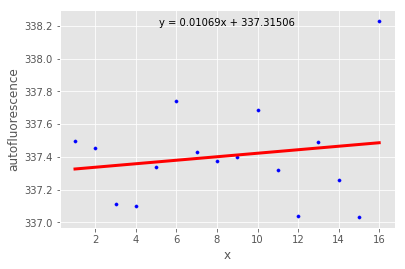

In [73]:
#create auto scatter plot with auto linear trendline
plt.scatter(master_trendlines.x, master_trendlines.auto_d0, color = 'blue', s = 10)
auto_trendline_values = polyval([a,b], master_trendlines.x)
plt.plot(master_trendlines.x, auto_trendline_values, linewidth = 3, color = 'red')
plt.title(auto_linear_trendline_equation, fontsize = 10, y = 0.9)
plt.xlabel('x')
plt.ylabel('autofluorescence')
#save auto scatter plot as PDF to working directory
plt.savefig('auto_plot_' + file_name + '.pdf')

In [74]:
#determine gcamp linear trendline equation
from pylab import *
(c, d) = polyfit(master_trendlines.x, master_trendlines.gc_d0, 1)
gcamp_linear_trendline_equation = 'y = ' + str(round(c, 5)) + 'x + ' + str(round(d, 5))

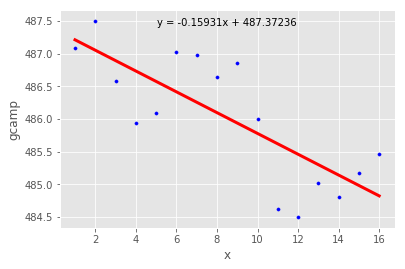

In [75]:
#create gcamp scatter plot with gcamp linear trendline
plt.scatter(master_trendlines.x, master_trendlines.gc_d0, color = 'blue', s = 10)
gcamp_trendline_values = polyval([c,d], master_trendlines.x)
plt.plot(master_trendlines.x, gcamp_trendline_values, linewidth = 3, color = 'red')
plt.title(gcamp_linear_trendline_equation, fontsize = 10, y = 0.9)
plt.xlabel('x')
plt.ylabel('gcamp')
#save gcamp scatter plot as PDF to working directory
plt.savefig('gcamp_plot_' + file_name + '.pdf') 

## 10.- Create a master_calculations pandas DataFrame. Input x values (ranging from 1 to the # of rows in master_input) into the auto/gcamp linear trendline equations to calculate auto/gcamp trendline y values. Subtract auto/gcamp trendline y values from auto/gcamp to calculate auto/gcamp fit. Add gcamp trendline y-intercept to auto/gcamp fit to calculate auto/gcamp final. Add auto/gcamp trendline y values, auto/gcamp fit, and auto/gcamp final to the master_calculations pandas DataFrame.

In [76]:
#create master_calculations pandas DataFrame
master_calculations = master_input
#reset master_calculations row index 
master_calculations = master_calculations.reset_index(drop = True)
#create x_master_calculations (ranging from 1 to # rows in master_calculations) pandas DataFrame
x_range_master_calculations = master_calculations.axes[0] - (master_calculations.axes[0][0] - 1)
x_master_calculations = pd.DataFrame({'x': x_range_master_calculations})
#add x_master_calculations to master_calculations 
master_calculations = pd.concat([x_master_calculations, master_calculations], axis = 1, join = 'inner')

In [77]:
#create auto_trendline_y pandas DataFrame 
auto_y_list = []
for x in x_range_master_calculations:
    y = a*x + b 
    auto_y_list.append(y)
auto_y_array = np.array(auto_y_list)
auto_trendline_y = pd.DataFrame({'auto_trendline_y': auto_y_array})
#add auto_trendline_y to master_calculations
master_calculations = pd.concat([master_calculations, auto_trendline_y], axis = 1, join = 'inner')
#create gcamp_trendline_y pandas DataFrame
gcamp_y_list = []
for x in x_range_master_calculations:
    y = c*x + d 
    gcamp_y_list.append(y)
gcamp_y_array = np.array(gcamp_y_list)
gcamp_trendline_y = pd.DataFrame({'gcamp_trendline_y': gcamp_y_array})
#add gcamp_trendline_y to master_calculations
master_calculations = pd.concat([master_calculations, gcamp_trendline_y], axis = 1, join = 'inner')

In [78]:
#subtract auto_trendline_y from auto to create auto_fit column in master_calculations
master_calculations['auto_fit'] = master_calculations['auto_d0'] - master_calculations['auto_trendline_y']
#subtract gcamp_trendline_y from gcamp to create gcamp_fit column in master_calculations
master_calculations['gcamp_fit'] = master_calculations['gc_d0'] - master_calculations['gcamp_trendline_y']

In [79]:
#add gcamp_trendline y-intercept to auto_fit to create auto_fit column in master_calculations
master_calculations['auto_final'] = d + master_calculations['auto_fit']
#add gcamp_trendline y-intercept to gcamp_fit to create gcamp_fit column in master_calculations
master_calculations['gcamp_final'] = d + master_calculations['gcamp_fit']

## 11.- Calculate delta f/f (dff). Add dff to the master_calculations pandas DataFrame. Write out the master_calculations pandas DataFrame as a csv file to the working directory. Create a dff line plot. Save the dff line plot as a PDF to the working directory.

In [80]:
#calculate delta f/f (dff) and create dff column in master_calculations
master_calculations['dff']= ((master_calculations['gcamp_final'] - master_calculations['auto_final'])/master_calculations['auto_final'])*100

In [81]:
#write out master_calculations as a csv file to working directory
master_calculations.to_csv('master_calculations_' + file_name + '.csv') 

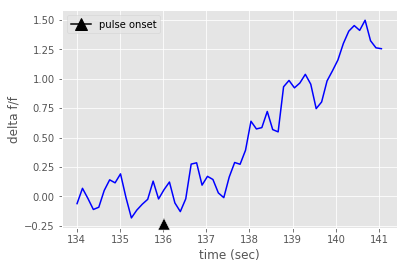

In [165]:
#determine the rows in which pulse occurs
pulse_rows_dff = master_calculations.loc[master_calculations.pulses_d0 > 1].index[:].tolist()
#determine the rows in which pulse onset occurs
pulse_onset_rows_dff = [pulse_rows_dff[0]]
for i in range(2, len(pulse_rows_dff)):
    if pulse_rows_dff[i] > pulse_rows_dff[i - 1] + 1: 
        pulse_onset_rows_dff.append(pulse_rows_dff[i])
#determine the times in which pulse onset occurs
pulse_onset_time_dff = list(master_calculations.time.loc[pulse_onset_rows_dff])
#create dff line plot
fig, ax = plt.subplots()
ax.plot(master_calculations.time, master_calculations.dff, color = 'blue')
ax.set_xlabel('time (sec)')
ax.set_ylabel('delta f/f')
x = 0
while x < len(pulse_onset_time_dff):
    ax.annotate(' ', xy =(pulse_onset_time_dff[x], min(master_calculations.dff)), arrowprops = dict(facecolor = 'black', shrink = 0.05))
    x = x + 1
arrow = mlines.Line2D([], [], color = 'black', marker = '^', markersize = 12, label = 'pulse onset')
ax.legend(handles = [arrow])
#save dff line plot as PDF to working directory
fig.savefig('dff_plot_' + file_name + '.pdf') 

## 12.- Create a method for the DF_F_analysis

In [21]:
def DF_F_analysis(indx, lower, upper, m_df):
    #create pulses_onset
    pulse_onset = indx #IMPORTANT - can change number to any of the numbers in pulse_onset_rows
    if pulse_onset in pulse_onset_rows:
        print('pulse_onset =', pulse_onset)
    else:
        raise ValueError('pulse_onset not found in pulse_onset_rows')
    #create begin_input 
    begin_input = pulse_onset - lower #IMPORTANT - can change number to any number of rows before shock onset
    print('begin_input =', begin_input)
    #create last_row
    last_row = len(m_df) - pulse_onset - 1
    #create end_input
    end_input = pulse_onset + upper #IMPORTANT - can change number to any number of rows after shock onset or to last_row for the last row in the data set
    print('end_input =', end_input)
    #create file name for future files
    file_name = 'A1_pellet_' + str(indx) #IMPORTANT - to change file name, format as 'file name'
    print(file_name)
    
    #create master_input pandas DataFrame
    master_input = m_df[begin_input:end_input + 1]
    
    #create master_trendlines pandas DataFrame
    master_trendlines = master_input.loc[begin_input:pulse_onset - 1]
    #reset master_trendlines row index 
    master_trendlines = master_trendlines.reset_index(drop = True)
    #create x_master_trendlines (ranging from 1 to # rows in master_trendlines) pandas DataFrame
    x_range_master_trendlines = master_trendlines.axes[0] - (master_trendlines.axes[0][0] - 1)
    x_master_trendlines = pd.DataFrame({'x': x_range_master_trendlines})
    #add x_master_trendlines to master_trendlines 
    master_trendlines = pd.concat([x_master_trendlines, master_trendlines], axis=1, join='inner')
    
    #determine gcamp linear trendline equation
    (a, b) = polyfit(master_trendlines.x, master_trendlines.auto_d0, 1)
    auto_linear_trendline_equation = 'y = ' + str(round(a, 5)) + 'x + ' + str(round(b, 5))
    
    #create auto scatter plot with auto linear trendline
    plt.scatter(master_trendlines.x, master_trendlines.auto_d0, color = 'blue', s = 10)
    auto_trendline_values = polyval([a,b], master_trendlines.x)
    plt.plot(master_trendlines.x, auto_trendline_values, linewidth = 3, color = 'red')
    plt.title(auto_linear_trendline_equation, fontsize = 10, y = 0.9)
    plt.xlabel('x')
    plt.ylabel('autofluorescence')
    #save auto scatter plot as PDF to working directory
    plt.show()
    plt.savefig('auto_plot_' + file_name + '.pdf')
    
    #determine gcamp linear trendline equation
    (c, d) = polyfit(master_trendlines.x, master_trendlines.gc_d0, 1)
    gcamp_linear_trendline_equation = 'y = ' + str(round(c, 5)) + 'x + ' + str(round(d, 5))
    
    #create gcamp scatter plot with gcamp linear trendline
    plt.scatter(master_trendlines.x, master_trendlines.gc_d0, color = 'blue', s = 10)
    gcamp_trendline_values = polyval([c,d], master_trendlines.x)
    plt.plot(master_trendlines.x, gcamp_trendline_values, linewidth = 3, color = 'red')
    plt.title(gcamp_linear_trendline_equation, fontsize = 10, y = 0.9)
    plt.xlabel('x')
    plt.ylabel('gcamp')
    #save gcamp scatter plot as PDF to working directory
    plt.show()
    plt.savefig('gcamp_plot_' + file_name + '.pdf')
    
    
    #create master_calculations pandas DataFrame
    master_calculations = master_input
    #reset master_calculations row index 
    master_calculations = master_calculations.reset_index(drop = True)
    #create x_master_calculations (ranging from 1 to # rows in master_calculations) pandas DataFrame
    x_range_master_calculations = master_calculations.axes[0] - (master_calculations.axes[0][0] - 1)
    x_master_calculations = pd.DataFrame({'x': x_range_master_calculations})
    #add x_master_calculations to master_calculations 
    master_calculations = pd.concat([x_master_calculations, master_calculations], axis = 1, join = 'inner')
    
    #create auto_trendline_y pandas DataFrame 
    auto_y_list = []
    for x in x_range_master_calculations:
        y = a*x + b 
        auto_y_list.append(y)
    auto_y_array = np.array(auto_y_list)
    auto_trendline_y = pd.DataFrame({'auto_trendline_y': auto_y_array})
    #add auto_trendline_y to master_calculations
    master_calculations = pd.concat([master_calculations, auto_trendline_y], axis = 1, join = 'inner')
    #create gcamp_trendline_y pandas DataFrame
    gcamp_y_list = []
    for x in x_range_master_calculations:
        y = c*x + d 
        gcamp_y_list.append(y)
    gcamp_y_array = np.array(gcamp_y_list)
    gcamp_trendline_y = pd.DataFrame({'gcamp_trendline_y': gcamp_y_array})
    #add gcamp_trendline_y to master_calculations
    master_calculations = pd.concat([master_calculations, gcamp_trendline_y], axis = 1, join = 'inner')
    
    #subtract auto_trendline_y from auto to create auto_fit column in master_calculations
    master_calculations['auto_fit'] = master_calculations['auto_d0'] - master_calculations['auto_trendline_y']
    #subtract gcamp_trendline_y from gcamp to create gcamp_fit column in master_calculations
    master_calculations['gcamp_fit'] = master_calculations['gc_d0'] - master_calculations['gcamp_trendline_y']
    
    #add gcamp_trendline y-intercept to auto_fit to create auto_fit column in master_calculations
    master_calculations['auto_final'] = d + master_calculations['auto_fit']
    #add gcamp_trendline y-intercept to gcamp_fit to create gcamp_fit column in master_calculations
    master_calculations['gcamp_final'] = d + master_calculations['gcamp_fit']
    
    #calculate delta f/f (dff) and create dff column in master_calculations
    master_calculations['dff']= ((master_calculations['gcamp_final'] - master_calculations['auto_final'])/master_calculations['auto_final'])*100

    #write out master_calculations as a csv file to working directory
    master_calculations.to_csv('master_calculations_' + file_name + '.csv')
    
    #determine the rows in which pulse occurs
    pulse_rows_dff = master_calculations.loc[master_calculations.pulses_d0 > 1].index[:].tolist()
    #determine the rows in which pulse onset occurs
    pulse_onset_rows_dff = [pulse_rows_dff[0]]
    for i in range(2, len(pulse_rows_dff)):
        if pulse_rows_dff[i] > pulse_rows_dff[i - 1] + 1: 
            pulse_onset_rows_dff.append(pulse_rows_dff[i])
    #determine the times in which pulse onset occurs
    pulse_onset_time_dff = list(master_calculations.time.loc[pulse_onset_rows_dff])
    #create dff line plot
    fig, ax = plt.subplots()
    ax.plot(master_calculations.time, master_calculations.dff, color = 'blue')
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('delta f/f')
    x = 0
    while x < len(pulse_onset_time_dff):
        ax.annotate(' ', xy =(pulse_onset_time_dff[x], min(master_calculations.dff)), arrowprops = dict(facecolor = 'black', shrink = 0.05))
        x = x + 1
    arrow = mlines.Line2D([], [], color = 'black', marker = '^', markersize = 12, label = 'pulse onset')
    ax.legend(handles = [arrow])
    #save dff line plot as PDF to working directory
    fig.savefig('dff_plot_' + file_name + '.pdf') 
    
    print('Success')
    


In [22]:
# Showing where (what rows) the rest of the pulses are located
subset = master_df[master_df['pulses_d0'] == 5]
print(subset)

              time     auto_d0       gc_d0  pulses_d0
1081    136.021279  337.760132  485.206604        5.0
1224    154.014843  336.522797  485.088226        5.0
1320    166.094438  336.857880  482.434509        5.0
1407    177.041572  336.672577  483.199310        5.0
1582    199.061668  336.933838  485.312592        5.0
2456    309.036319  335.745178  489.031189        5.0
2560    322.122547  335.544067  482.522827        5.0
2671    336.089580  335.046448  483.736481        5.0
2750    346.030080  335.086700  481.433167        5.0
3315    417.123533  334.461121  481.133667        5.0
3895    490.104422  334.813660  480.102600        5.0
3966    499.038290  334.444855  478.310699        5.0
4046    509.104620  334.493164  477.842926        5.0
4284    539.051950  334.143738  479.878021        5.0
5381    677.086495  333.200745  470.659149        5.0
5484    690.046894  333.327606  471.144196        5.0
5579    702.000660  333.560761  469.335388        5.0
6756    850.101535  332.0511

pulse_onset = 8290
begin_input = 8250
end_input = 8370
A1_pellet_8290


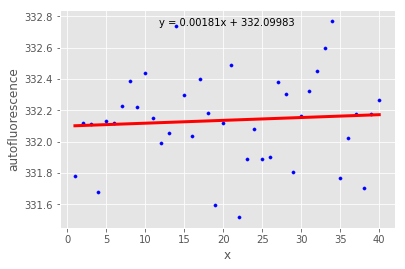

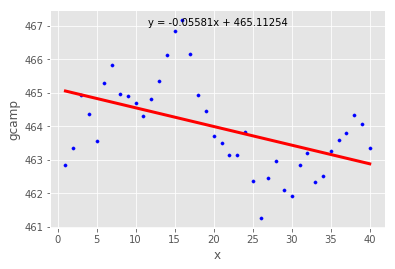

Success


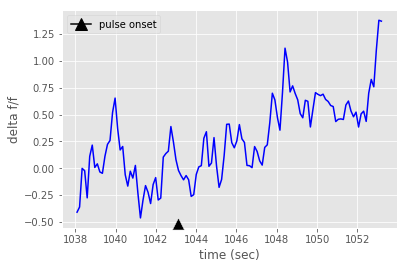

In [23]:
DF_F_analysis(indx=8290, lower=40, upper=80, m_df=master_df)